# Thermochemical benchmark: atomisation of closed shell molecules with core correlation

Bak et al., [doi:10.1063/1.1357225](https://doi.org/10.1063/1.1357225) and [doi:10.1063/1.481544](https://doi.org/10.1063/1.481544)

In [1]:
import pymolpro
import pandas as pd

In [2]:
backend = 'local'  # If preferred, change this to one of the backends in your ~/.sjef/molpro/backends.xml that is ssh-accessible
project_name = 'Bak2000_atomisations'
parallel = None  # how many jobs to run at once

In [3]:
methods = {"HF": ["hf", "uhf"],
"MP2": ["mp2", "ump2"],
# "MP3": ["mp3", "ump3"],
# "MP4": ["mp4", "ump4"],
"CCSD": ["ccsd", "uccsd"], "CCSD(T)": ["ccsd(t)", "uccsd(t)"], }
bases = ['cc-pCVDZ', 'cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z']

In [4]:
db = pymolpro.database.load("Bak2000_atomisations")

In [5]:
results = {}
for method in methods:
    results[method] = {}
    for basis in bases:
        results[method][basis] = pymolpro.database.run(db, methods[method], basis, location=project_name,
                                                       backend=backend,
                                                       preamble="core,small", parallel=parallel)

In [6]:
for method in methods:
    for result in pymolpro.database.basis_extrapolate(results[method].values(), results['HF'].values()):
        results[method][result.basis] = result
    for basis in results[method]:
        if basis not in bases: bases.append(basis)

In [10]:
pd.set_option('display.precision', 2)
method_errors=pymolpro.database.analyse([results[method]['cc-pCV[45]Z'] for method in methods], db, 'kj/mol')[
    'reaction statistics']
with open(project_name + '.method_errors.tex', 'w') as tf:
    tf.write('\\ifx\\toprule\\undefined\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}\\fi') # or \usepackage{booktabs}
    tf.write(method_errors.style.format(precision=2).to_latex(hrules=True,multicol_align='c',caption='Method errors'))
method_errors

,UHF,UMP2,UCCSD,UCCSD(T)
,cc-pCV[45]Z,cc-pCV[45]Z,cc-pCV[45]Z,cc-pCV[45]Z
MSD,-405.05,30.04,-28.48,0.08
STDEVD,143.84,32.64,16.43,1.12
MAD,405.05,35.11,28.50,0.90
MAXD,598.79,112.20,58.55,2.45
RMSD,428.32,43.60,32.62,1.09


In [8]:
pd.set_option('display.precision', 2)
basis_errors=pymolpro.database.analyse([results['CCSD(T)'][basis] for basis in bases], db, 'kj/mol')[
    'reaction statistics']
with open(project_name + '.basis_errors.tex', 'w') as tf:
    tf.write('\\ifx\\toprule\\undefined\\def\\toprule{\\hline\\hline}\n\\def\\midrule{\\hline}\n\\def\\bottomrule{\\hline\\hline}\\fi') # or \usepackage{booktabs}
    tf.write(basis_errors.style.format(precision=2).to_latex(hrules=True,multicol_align='c',caption='Basis errors'))
basis_errors

UCCSD(T)                                                               
       cc-pCVDZ cc-pCVTZ cc-pCVQZ cc-pCV5Z cc-pCV[23]Z cc-pCV[34]Z cc-pCV[45]Z
MSD     -103.07   -34.00   -13.46    -6.61      -14.66       -0.23        0.08
STDEVD    37.19    13.58     5.63     3.08        8.39        2.15        1.12
MAD      103.07    34.00    13.46     6.61       14.74        1.68        0.90
MAXD     155.71    51.58    20.15    10.71       29.53        4.01        2.45
RMSD     109.18    36.45    14.52     7.25       16.76        2.10        1.09

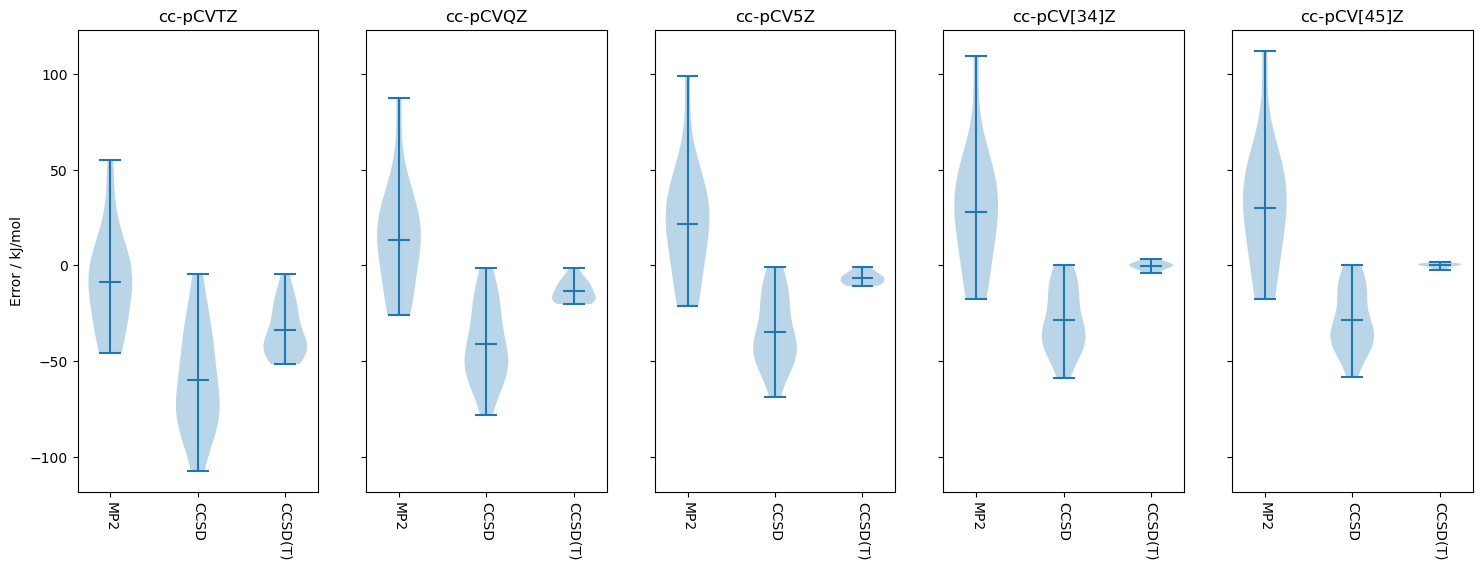

In [9]:
import matplotlib.pyplot as plt

methods_pruned = [method for method in methods if method != 'HF']
bases_pruned = ['cc-pCVTZ', 'cc-pCVQZ', 'cc-pCV5Z', 'cc-pCV[34]Z', 'cc-pCV[45]Z']
fig, panes = plt.subplots(nrows=1, ncols=len(bases_pruned), sharey=True, figsize=(18, 6))

for pane in range(len(bases_pruned)):
    data = []
    for method in methods_pruned:
        data.append(
            pymolpro.database.analyse(results[method][bases_pruned[pane]],
                                      db,'kJ/mol')['reaction energy deviations'].to_numpy()[:, 0]
        )
    panes[pane].violinplot(data, showmeans=True, showextrema=True, vert=True, bw_method='silverman')
    panes[pane].set_xticks(range(1, len(methods_pruned) + 1), labels=methods_pruned, rotation=-90)
    panes[pane].set_title(bases_pruned[pane])
panes[0].set_ylabel('Error / kJ/mol')
plt.savefig(project_name + ".violin.pdf")
